Task 1

In [27]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# ---------- Вспомогательные функции ----------
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def nll_loss(y_pred, y_true):
    eps = 1e-8
    return -torch.mean(y_true * torch.log(y_pred + eps) + (1 - y_true) * torch.log(1 - y_pred + eps))

def accuracy(y_pred, y_true):
    pred_labels = (y_pred >= 0.5).float()
    return (pred_labels == y_true).float().mean().item()

# ---------- Обучение одного нейрона ----------
def train_single_neuron(features, labels, initial_weights, initial_bias, learning_rate, epochs, batch_size=1):
    X = torch.tensor(features, dtype=torch.float32)
    y = torch.tensor(labels, dtype=torch.float32).reshape(-1, 1)
    
    w = torch.tensor(initial_weights, dtype=torch.float32).reshape(-1, 1)
    b = torch.tensor(initial_bias, dtype=torch.float32)
    
    nll_values = []
    n_samples = X.shape[0]
    
    for epoch in range(epochs):
        perm = torch.randperm(n_samples)
        X = X[perm]
        y = y[perm]
        
        epoch_loss = 0.0
        for i in range(0, n_samples, batch_size):
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]
            
            # Forward
            z = X_batch @ w + b
            y_pred = sigmoid(z)
            
            # Loss
            loss = nll_loss(y_pred, y_batch)
            epoch_loss += loss.item()
            
            # Backprop
            grad_z = y_pred - y_batch
            grad_w = X_batch.T @ grad_z / batch_size
            grad_b = torch.mean(grad_z)
            
            # Update
            w -= learning_rate * grad_w
            b -= learning_rate * grad_b
        
        avg_loss = epoch_loss / (n_samples / batch_size)
        nll_values.append(round(avg_loss, 4))
    
    return w.flatten().tolist(), b.item(), nll_values


In [28]:
features = [[1.0, 2.0], [2.0, 1.0], [-1.0, -2.0]]
labels = [1, 0, 0]
initial_weights = [0.1, -0.2]
initial_bias = 0.0
learning_rate = 0.1
epochs = 2

w, b, nll_vals = train_single_neuron(
    features, labels, initial_weights, initial_bias, learning_rate, epochs, batch_size=1
)

print("Updated weights:", w)
print("Updated bias:", b)
print("NLL per epoch:", nll_vals)


Updated weights: [0.11072127521038055, 0.13424493372440338]
Updated bias: -0.09682720899581909
NLL per epoch: [0.8314, 0.731]


In [29]:
# ---------- Загрузка и подготовка данных ----------
train_x = pd.read_csv("train_x.csv")
train_y = pd.read_csv("train_y.csv")

# Уберём ID-колонку
X = train_x.iloc[:, 1:].values
y_year = train_y.iloc[:, 1].values

# Бинарные метки
y = (y_year >= 2000).astype(int)

# Фильтруем только два года (пример: 1990 и 2000)
mask = (y_year == 1990) | (y_year == 2000)
X_sub = X[mask]
y_sub = y[mask]

# Нормализация признаков
X_sub = (X_sub - X_sub.mean(axis=0)) / (X_sub.std(axis=0) + 1e-8)

# Деление на train/test
X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, test_size=0.2, random_state=42)


SGD: Test Accuracy = 0.729, Test NLL = 0.6337
Mini-Batch: Test Accuracy = 0.736, Test NLL = 0.4979


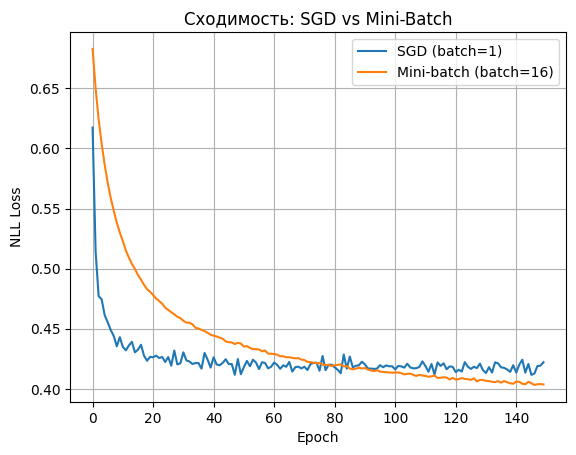

In [30]:
# ---------- Обучение двух вариантов ----------
initial_weights = [0.0] * X_train.shape[1]
initial_bias = 0.0
learning_rate = 0.01
epochs = 150

# SGD
w_sgd, b_sgd, loss_sgd = train_single_neuron(
    X_train, y_train, initial_weights, initial_bias, learning_rate, epochs, batch_size=1
)

# Mini-Batch
w_mb, b_mb, loss_mb = train_single_neuron(
    X_train, y_train, initial_weights, initial_bias, learning_rate, epochs, batch_size=16
)

# ---------- Оценка на тесте ----------
def predict(X, w, b):
    X_t = torch.tensor(X, dtype=torch.float32)
    w_t = torch.tensor(w, dtype=torch.float32).reshape(-1, 1)
    b_t = torch.tensor(b, dtype=torch.float32)
    return sigmoid(X_t @ w_t + b_t)

y_pred_sgd = predict(X_test, w_sgd, b_sgd)
y_pred_mb = predict(X_test, w_mb, b_mb)

acc_sgd = accuracy(y_pred_sgd, torch.tensor(y_test).reshape(-1, 1))
acc_mb = accuracy(y_pred_mb, torch.tensor(y_test).reshape(-1, 1))

loss_test_sgd = nll_loss(y_pred_sgd, torch.tensor(y_test).reshape(-1, 1)).item()
loss_test_mb = nll_loss(y_pred_mb, torch.tensor(y_test).reshape(-1, 1)).item()

# ---------- Результаты ----------
print(f"SGD: Test Accuracy = {acc_sgd:.3f}, Test NLL = {loss_test_sgd:.4f}")
print(f"Mini-Batch: Test Accuracy = {acc_mb:.3f}, Test NLL = {loss_test_mb:.4f}")

# ---------- График сходимости ----------
plt.plot(loss_sgd, label='SGD (batch=1)')
plt.plot(loss_mb, label='Mini-batch (batch=16)')
plt.xlabel('Epoch')
plt.ylabel('NLL Loss')
plt.title('Сходимость: SGD vs Mini-Batch')
plt.legend()
plt.grid(True)
plt.show()

SGD уменьшает ошибку быстрее, но при этом значительно шумнее(из-за чего не может в конце концов сойтись) - в отличии от mini-batch, который движется медленно, но верно.

Task 3

In [31]:
class AdamWOptimizer:
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.01):
        """
        params: список torch.Tensor параметров (например, [w, b])
        """
        self.params = params
        self.lr = lr
        self.betas = betas
        self.eps = eps
        self.weight_decay = weight_decay
        self.m = [torch.zeros_like(p) for p in params]
        self.v = [torch.zeros_like(p) for p in params]
        self.t = 0

    def step(self, grads):
        """
        grads: список градиентов для каждого параметра (того же размера, что params)
        """
        self.t += 1
        beta1, beta2 = self.betas

        for i, (p, g) in enumerate(zip(self.params, grads)):
            self.m[i] = beta1 * self.m[i] + (1 - beta1) * g
            self.v[i] = beta2 * self.v[i] + (1 - beta2) * (g * g)

            m_hat = self.m[i] / (1 - beta1 ** self.t)
            v_hat = self.v[i] / (1 - beta2 ** self.t)

            # AdamW update (с весовой регуляризацией)
            p -= self.lr * (m_hat / (torch.sqrt(v_hat) + self.eps) + self.weight_decay * p)


In [32]:
def sigmoid_neuron_adamw(features, labels, epochs=100, lr=0.01):
    X = torch.tensor(features, dtype=torch.float32)
    y = torch.tensor(np.array(labels), dtype=torch.float32).view(-1, 1)
    
    n_features = X.shape[1]
    w = torch.zeros((n_features, 1), dtype=torch.float32, requires_grad=False)
    b = torch.zeros(1, dtype=torch.float32, requires_grad=False)
    
    optimizer = AdamWOptimizer(params=[w, b], lr=lr)
    nll_values = []

    for epoch in range(epochs):
        z = X @ w + b
        y_pred = torch.sigmoid(z)
        loss = -torch.mean(y * torch.log(y_pred + 1e-8) + (1 - y) * torch.log(1 - y_pred + 1e-8))
        nll_values.append(round(loss.item(), 4))


        grad_y_pred = y_pred - y
        grad_w = (X.T @ grad_y_pred) / X.shape[0]
        grad_b = torch.mean(grad_y_pred)

        optimizer.step([grad_w, grad_b])

    return w, b, nll_values

In [33]:
def test_adamw_update():
    # Тест 1 — проверка обновления параметров
    w = torch.tensor([1.0, 2.0])
    b = torch.tensor([0.5])
    opt = AdamWOptimizer([w, b], lr=0.01)
    
    grad_w = torch.tensor([0.1, -0.2])
    grad_b = torch.tensor([0.05])
    opt.step([grad_w, grad_b])

    assert not torch.allclose(w, torch.tensor([1.0, 2.0])), "Weights did not update"
    assert not torch.allclose(b, torch.tensor([0.5])), "Bias did not update"
    print("Test 1 passed: Parameters update correctly.")

def test_adamw_weight_decay():
    # Тест 2 — weight decay уменьшает веса
    w = torch.tensor([10.0, -5.0])
    b = torch.tensor([0.0])
    opt = AdamWOptimizer([w, b], lr=0.01, weight_decay=0.1)
    grad_w = torch.zeros_like(w)
    grad_b = torch.zeros_like(b)
    opt.step([grad_w, grad_b])
    assert torch.all(torch.abs(w) < torch.tensor([10.0, 5.0])), "Weight decay not applied"
    print("Test 2 passed: Weight decay works.")

def test_adamw_convergence():
    # Тест 3 — сходимость на простой функции y = x^2
    w = torch.tensor([5.0], dtype=torch.float32)
    opt = AdamWOptimizer([w], lr=0.1)
    for _ in range(100):
        grad = 2 * w  # d(x^2)/dx
        opt.step([grad])
    assert abs(w.item()) < 0.1, "AdamW did not converge near zero"
    print("Test 3 passed: Convergence on simple quadratic.")

# Запускаем тесты
test_adamw_update()
test_adamw_weight_decay()
test_adamw_convergence()


Test 1 passed: Parameters update correctly.
Test 2 passed: Weight decay works.
Test 3 passed: Convergence on simple quadratic.


In [36]:
def train_neuron_adamw(X_train, y_train, lr=0.01, epochs=50, weight_decay=0.01):
    X = torch.tensor(X_train, dtype=torch.float32)
    y = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    
    w = torch.zeros(X.shape[1], 1)
    b = torch.tensor(0.0)
    
    optimizer = AdamWOptimizer([w, b], lr=lr, weight_decay=weight_decay)
    nll_history = []

    for epoch in range(epochs):
        z = X @ w + b
        y_pred = 1 / (1 + torch.exp(-z))
        
        # Loss
        loss = -torch.mean(y * torch.log(y_pred + 1e-8) + (1 - y) * torch.log(1 - y_pred + 1e-8))
        nll_history.append(round(loss.item(), 4))
        
        # Gradients
        grad_z = y_pred - y
        grad_w = X.T @ grad_z / len(y)
        grad_b = torch.mean(grad_z)
        
        optimizer.step([grad_w, grad_b])
        
    return w.flatten().tolist(), b.item(), nll_history


Test Accuracy: 0.7222
Test NLL: 0.6085


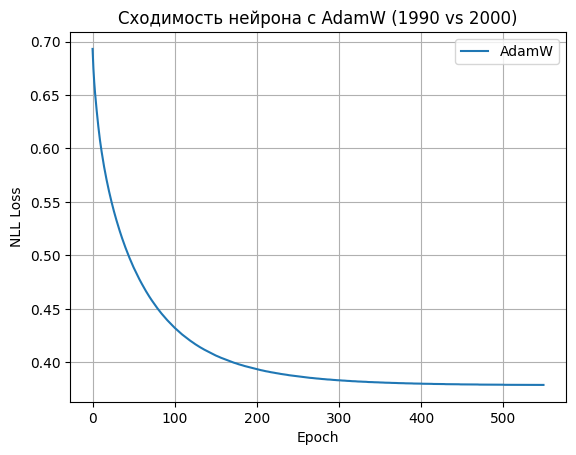

In [39]:
# Обучение
w_adamw, b_adamw, nll_history = train_neuron_adamw(X_train, y_train, lr=0.01, epochs=550, weight_decay=0.01)

# Предсказания на тесте
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).reshape(-1,1)
y_pred_test = 1 / (1 + torch.exp(-(X_test_t @ torch.tensor(w_adamw).reshape(-1,1) + b_adamw)))

# Accuracy
y_pred_labels = (y_pred_test >= 0.5).float()
accuracy = (y_pred_labels == y_test_t).float().mean().item()
print(f"Test Accuracy: {accuracy:.4f}")

# NLL на тесте
loss_test = -torch.mean(y_test_t * torch.log(y_pred_test + 1e-8) + (1 - y_test_t) * torch.log(1 - y_pred_test + 1e-8)).item()
print(f"Test NLL: {loss_test:.4f}")

# График сходимости
plt.plot(nll_history, label='AdamW')
plt.xlabel('Epoch')
plt.ylabel('NLL Loss')
plt.title('Сходимость нейрона с AdamW (1990 vs 2000)')
plt.grid(True)
plt.legend()
plt.show()


AdamW — это современный оптимизатор, который объединяет три ключевые идеи:

Адаптивная скорость обучения для каждого параметра

- Веса, которые получают большие градиенты, получают меньшее изменение за шаг, а веса с маленькими градиентами — большее.

Моментум (ускорение по направлению градиента)

- Алгоритм не смотрит только на текущий градиент, а учитывает «скользящую историю» градиентов.

Weight Decay (регуляризация весов)

- Чтобы нейрон не «раздувал» веса до огромных значений, AdamW специально уменьшает их при каждом шаге, независимо от градиента.

- В отличие от обычного L2-регуляризатора в Adam, это делается напрямую в формуле обновления, что предотвращает смещение адаптивного шага.

Еще понравилась интересная аналогия из интернета:

Представьте, что вы катите шарик по гористой поверхности (это функция ошибки):

- SGD: шарик прыгает вниз по склонам, сильно подпрыгивая на кочках.

- Momentum: шарик набирает скорость и сглаживает колебания.

- Adam: шарик ещё умнее — быстрее замедляется там, где кочки большие, и ускоряется там, где склоны пологие.

- AdamW: добавляется ещё тормоз, который постепенно уменьшает размер шарика (веса), чтобы он не разгонялся слишком сильно.